## Ideal mass-spring

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits import mplot3d

### Data generation

In [ ]:
np.random.seed(1234)
tf.random.set_seed(1234)

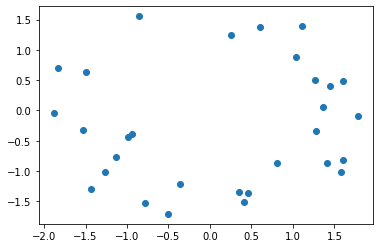

In [ ]:
r = np.random.random(30) + 1
theta = np.random.random(30)*2*np.pi

x0 = 0
y0 = 0

x = x0 + r*np.cos(theta)
y = y0 + r*np.sin(theta)

plt.scatter(x,y)

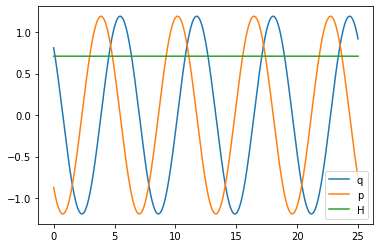

In [ ]:
m =1
k = 1
omega = np.sqrt(m/k)
t = np.linspace(0,25,2501)
q = x[0]*np.cos(omega*t) + y[0]*np.sin(omega*t)
p = (-x[0]*np.sin(omega*t) + y[0]*np.cos(omega*t))*omega
plt.plot(t,q)
plt.plot(t,p)
plt.plot(t,0.5*(p**2 + q**2))
plt.legend(['q','p','H'])

In [ ]:
Q = np.zeros((30,2501))
P = np.zeros((30,2501))
T = np.zeros((30,2501))
for i in range(30):
  Q[i] = x[i]*np.cos(omega*t) + y[i]*np.sin(omega*t)
  P[i] = (-x[i]*np.sin(omega*t) + y[i]*np.cos(omega*t))*omega
  T[i] = t
print(f"Shape of Q is {Q.shape}")
print(f"Shape of P is {P.shape}")

Shape of Q is (30, 2501)
Shape of P is (30, 2501)


In [ ]:
Q_dot = P
P_dot = -Q*(omega**2)

In [ ]:
inputs_train = tf.convert_to_tensor(np.vstack([Q[:25,:].flatten(),P[:25,:].flatten()]).T)
derivs_train = tf.convert_to_tensor(np.vstack([-P_dot[:25,:].flatten(), Q_dot[:25,:].flatten()]).T)

print("Shape of inputs is: ", inputs_train.shape)
print("Shape of derivatives is:", derivs_train.shape)

Shape of inputs is:  (62525, 2)
Shape of derivatives is: (62525, 2)


In [ ]:
inputs_test = tf.convert_to_tensor(np.vstack([Q[25:,:].flatten(),P[25:,:].flatten()]).T)
derivs_test = tf.convert_to_tensor(np.vstack([-P_dot[25:,:].flatten(), Q_dot[25:,:].flatten()]).T)

print("Shape of inputs is: ", inputs_test.shape)
print("Shape of derivatives is:", derivs_test.shape)

Shape of inputs is:  (12505, 2)
Shape of derivatives is: (12505, 2)


### Neural network model

In [ ]:
class Hamiltonian(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(200, activation ='tanh')
    self.dense2 = tf.keras.layers.Dense(200, activation ='tanh')
    self.dense3 = tf.keras.layers.Dense(1, use_bias = False)

  def hamilt_net(self,inputs):
    x = inputs
    x = self.dense1(x)
    x = self.dense2(x)
    output = self.dense3(x)
    return output

  def call(self,inputs):
    with tf.GradientTape() as tape:
      tape.watch(inputs)
      y_pred = self.hamilt_net(inputs)
    derivatives = tape.gradient(y_pred, inputs)
    return derivatives

  def loss(self, predictions, labels):
    loss = tf.reduce_mean((predictions - labels)**2)
    return loss
  


In [ ]:


model = Hamiltonian()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

num_epochs = 100
batch_size = 512
num_batches = inputs_train.shape[0]//batch_size
loss_list = []
for i in range(num_epochs):
  batch_loss = []   
  for j in range(num_batches):
    start = j*batch_size
    end   = (j+1)*batch_size
    with tf.GradientTape() as tape:
      y_pred = model.call(inputs_train[start:end,:])
      loss = model.loss(y_pred, derivs_train[start:end,:])
    
    gradients = tape.gradient(loss, model.trainable_variables)
    #print(gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    batch_loss.append(loss)
  loss_list.append(sum(batch_loss)/len(batch_loss))
  if i % 10 == 0:
    print(f"Loss on training set after {i} training steps: {sum(batch_loss)/len(batch_loss)}")

Loss on training set after 0 training steps: 0.7028658414441149
Loss on training set after 10 training steps: 0.0008319170293873422
Loss on training set after 20 training steps: 0.0003316262279187802
Loss on training set after 30 training steps: 0.0009519405413267151
Loss on training set after 40 training steps: 0.0009678655623529932
Loss on training set after 50 training steps: 0.0007777364952238327
Loss on training set after 60 training steps: 0.00016838216841967874
Loss on training set after 70 training steps: 0.0002934065468643074
Loss on training set after 80 training steps: 0.0004093425726717916
Loss on training set after 90 training steps: 0.00041141382304100467


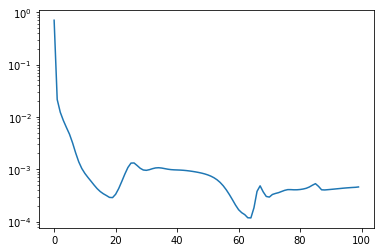

In [ ]:
plt.semilogy(loss_list)

In [ ]:
input = tf.random.normal([10,2]) #batch_sz, window_sz, num_features
output = model(input)
model.summary()

Model: "hamiltonian"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  600       
                                                                 
 dense_1 (Dense)             multiple                  40200     
                                                                 
 dense_2 (Dense)             multiple                  200       
                                                                 
Total params: 41,000
Trainable params: 41,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def gradient_function(t, x):
        #print(x)
        #print(t)
        inputs = tf.reshape(tf.convert_to_tensor(x),[-1,2])
        deriv = model.call(inputs).numpy()
        #print(deriv)
        pdot = -deriv[0,0]
        qdot = deriv[0,1]
        
        return [qdot, pdot]

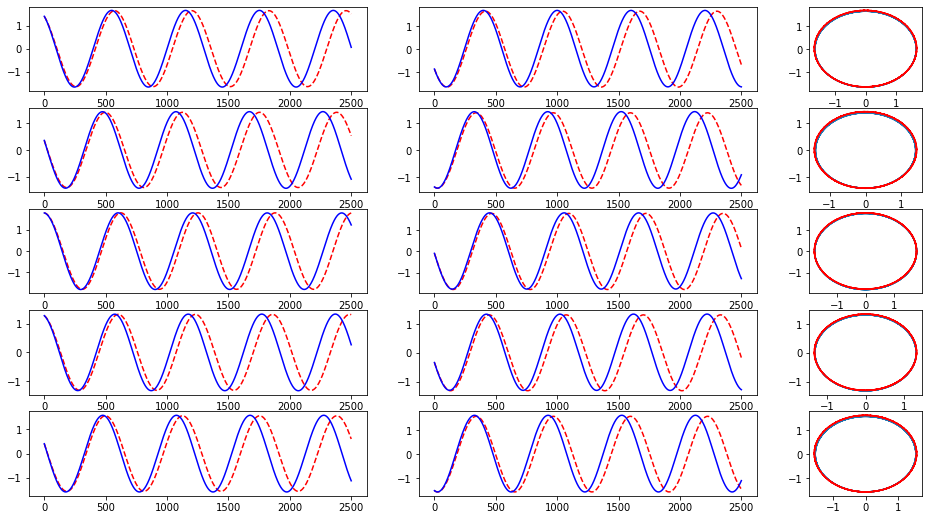

In [ ]:
fig, ax = plt.subplots(5,3, figsize = (16,9),gridspec_kw={'width_ratios': [3,3,1]})
relative_l2 = []
for i in range(5):
  q = Q[25+i,:]
  p = P[25+i,:]
  sol = solve_ivp(gradient_function,[0,25],[q[0], p[0]], t_eval = np.linspace(0,25,2501))
  #plt.figure()
  ax[i,0].plot(q,'--r')
  ax[i,0].plot(sol['y'][0,:],'b')
  #plt.figure()
  ax[i,1].plot(p,'--r')
  ax[i,1].plot(sol['y'][1,:],'b')
  #plt.figure()
  ax[i,2].plot(q,p)
  ax[i,2].plot(sol['y'][0,:],sol['y'][1,:],'--r')
  l2 = np.sqrt(np.sum((sol['y'][0,:] - q)**2 + (sol['y'][0,:] - q)**2))
  l2or = np.sqrt(np.sum((Q[27])**2 + np.array(P[27])**2))
  relative_l2.append(l2/l2or)

In [ ]:
np.mean(relative_l2)

0.5396179838909745

[]

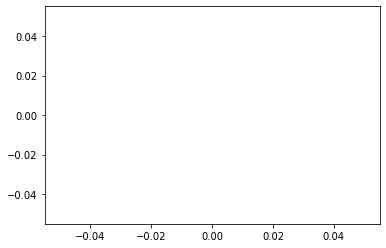

In [ ]:
plt.plot()

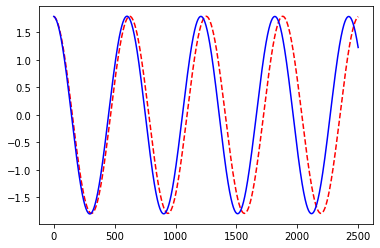

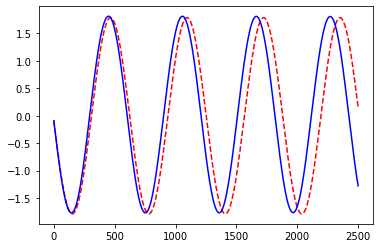

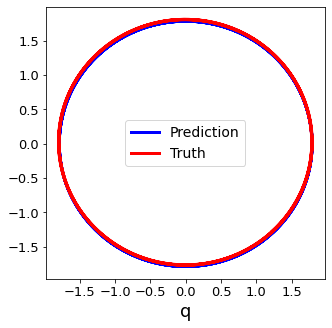

In [ ]:
for i in range(2,3):
  q = Q[25+i,:]
  p = P[25+i,:]
  sol = solve_ivp(gradient_function,[0,25],[q[0], p[0]], t_eval = np.linspace(0,25,2501))
  plt.figure()
  plt.plot(q,'--r')
  plt.plot(sol['y'][0,:],'b')
  plt.figure()
  plt.plot(p,'--r')
  plt.plot(sol['y'][1,:],'b')
  plt.figure(figsize = (5,5))
  plt.plot(q,p, '-b',linewidth = 3)
  plt.plot(sol['y'][0,:],sol['y'][1,:],'-r', linewidth = 3)
  plt.legend(['Prediction','Truth'], fontsize =14)
  plt.xticks(fontsize = 13)
  plt.yticks(fontsize = 13)
  plt.xlabel('q', fontsize = 18)
  #plt.ylabel('p', fontsize = 18)

### Multistep Neural Networks

In [ ]:
xn_1 = np.zeros((25*2500,2))
xn   = np.zeros((25*2500,2))

for i in range(25):
  start = i*2500
  end   = (i+1)*2500
  xn_1[start:end,0] = Q[i,:2500].T
  xn_1[start:end,1] = P[i,:2500].T
  xn[start:end,0]   = Q[i,1:].T
  xn[start:end,1]   = P[i,1:].T


xn_1 = tf.convert_to_tensor(xn_1, dtype = tf.float32)
xn   = tf.convert_to_tensor(xn,   dtype = tf.float32)

In [ ]:
class MultiStepNN(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(200, activation ='tanh')
    self.dense2 = tf.keras.layers.Dense(200, activation ='tanh')
    self.dense3 = tf.keras.layers.Dense(2)

  def call(self,inputs):
    x = inputs
    x = self.dense1(x)
    #x = self.dense2(x)
    output = self.dense3(x)
    return output

  def loss(self, xn_1, xn, fxn_1, fxn):
    dt = 1e-2
    loss = tf.reduce_mean(tf.reduce_sum((xn_1 - xn + 0.5* dt * (fxn_1 + fxn))**2, axis = 1))
    #loss =  tf.reduce_mean((tf.reduce_sum(inputs_processed, axis = 1) + 0.5*dt*tf.reduce_sum(predictions, axis =1))**2)
    return loss

In [ ]:
model = MultiStepNN()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
num_epochs = 100
batch_size = 512
num_batches = xn.shape[0]//batch_size
loss_list = []
for i in range(num_epochs):
  batch_loss = []   
  for j in range(num_batches):
    start = j*batch_size
    end   = (j+1)*batch_size
    with tf.GradientTape() as tape:
      y_pred_1 = model.call(xn_1[start:end,:])
      y_pred   = model.call(xn[start:end,:])
      #print(y_pred)
      #print(lorentz_data_proc[start:end,:,:])
      loss = model.loss(xn_1[start:end,:], xn[start:end,:], y_pred_1, y_pred)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    #print(gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    batch_loss.append(loss)
  loss_list.append(sum(batch_loss)/len(batch_loss))
  if i % 10 == 0:
    print(f"Loss on training set after {i} training steps: {sum(batch_loss)/len(batch_loss)}")

Loss on training set after 0 training steps: 3.094429484917782e-05
Loss on training set after 10 training steps: 2.8222565617852524e-08
Loss on training set after 20 training steps: 3.2222637003087584e-08
Loss on training set after 30 training steps: 1.9810961759958445e-08
Loss on training set after 40 training steps: 2.630550355320338e-08
Loss on training set after 50 training steps: 2.6626040039445797e-08
Loss on training set after 60 training steps: 2.4154852340529942e-08
Loss on training set after 70 training steps: 2.1900525837281748e-08
Loss on training set after 80 training steps: 2.004715327075246e-08
Loss on training set after 90 training steps: 1.8498996112725763e-08


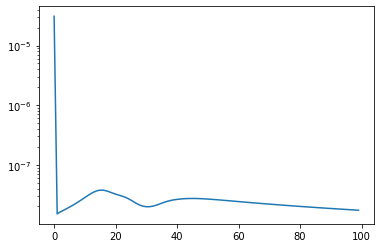

In [ ]:
plt.semilogy(loss_list)

In [ ]:
def gradient_function(t,x):
  inp = tf.convert_to_tensor(x[np.newaxis,:])
  deriv = model.call(inp).numpy()
  out = deriv[0,:]
  return out

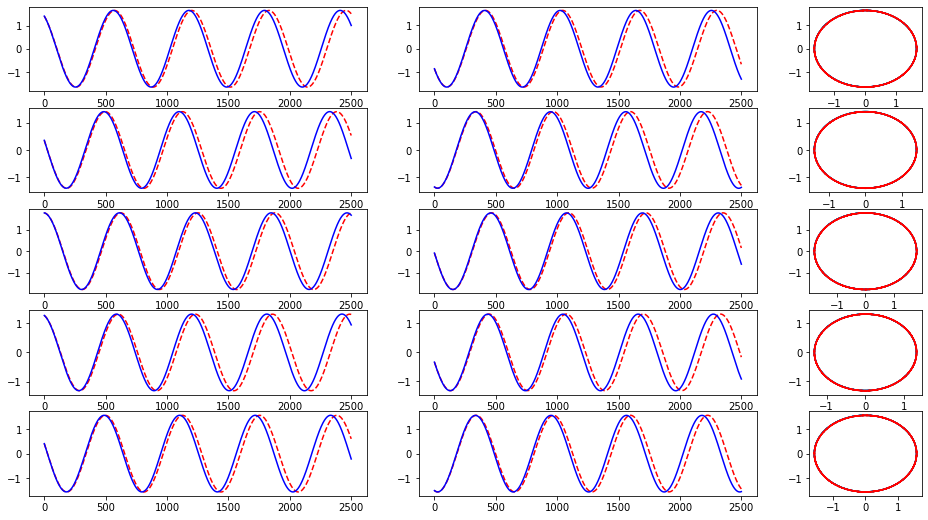

In [ ]:
fig, ax = plt.subplots(5,3, figsize = (16,9),gridspec_kw={'width_ratios': [3,3,1]})
relative_l2 = []
for i in range(5):
  q = Q[25+i,:]
  p = P[25+i,:]
  sol = solve_ivp(gradient_function,[0,25],[q[0], p[0]], t_eval = np.linspace(0,25,2501))
  #plt.figure()
  ax[i,0].plot(q,'--r')
  ax[i,0].plot(sol['y'][0,:],'b')
  #plt.figure()
  ax[i,1].plot(p,'--r')
  ax[i,1].plot(sol['y'][1,:],'b')
  #plt.figure()
  ax[i,2].plot(q,p)
  ax[i,2].plot(sol['y'][0,:],sol['y'][1,:],'--r')
  l2 = np.sqrt(np.sum((sol['y'][0,:] - q)**2 + (sol['y'][0,:] - q)**2))
  l2or = np.sqrt(np.sum((Q[27])**2 + np.array(P[27])**2))
  relative_l2.append(l2/l2or)

In [ ]:
np.mean(relative_l2)

0.2533900927365589

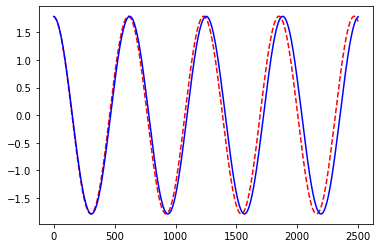

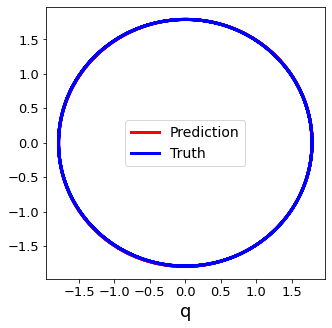

In [ ]:
for i in range(2,3):
  ini_cond = [Q[25+i, 0],P[25+i, 0]]

  sol = solve_ivp(gradient_function, [0,25], ini_cond, t_eval = np.linspace(0,25,2501))
  #sol_true = solve_ivp(Lorenz, [0,25], ini_cond, t_eval = np.linspace(0,25,2501))
  plt.figure()
  plt.plot(sol['y'][0,:],'--r')
  plt.plot(Q[25+i,:],'b')

  plt.figure(figsize = (5,5))
  plt.plot(sol['y'][0,:],sol['y'][1,:],'-r', linewidth = 3)
  plt.plot(Q[25 +i,:],P[25+i,:],'-b', linewidth = 3)
  plt.legend(['Prediction','Truth'], fontsize =14)
  plt.xticks(fontsize = 13)
  plt.yticks(fontsize = 13)
  plt.xlabel('q', fontsize = 18)

### LSTM

In [ ]:
window_size = 5
num_windows = 2501//window_size
remainder = (2501 - 1)%window_size
if remainder!=0:  
  Q_truncated = Q[:,:-remainder]
else:
  Q_truncated = Q

Q_inp = Q_truncated[:,:-1]
Q_inp = Q_inp.reshape((-1, window_size))

Q_tru = Q_truncated[:,1:]
Q_tru = Q_tru.reshape((-1, window_size))

if remainder!=0:
  P_truncated = P[:,:-remainder]
else:
  P_truncated = P

P_inp = P_truncated[:,:-1]
P_inp = P_inp.reshape((-1,window_size))

P_tru = P_truncated[:,1:]
P_tru = P_tru.reshape((-1,window_size))

In [ ]:
print(Q_tru.shape)
print(Q_inp.shape)

print(P_tru.shape)
print(P_inp.shape)

PQ_tru = np.stack((Q_tru,P_tru),axis = -1)
PQ_inp = np.stack((Q_inp,P_inp),axis = -1)
print(PQ_tru.shape)
print(PQ_inp.shape)

(15000, 5)
(15000, 5)
(15000, 5)
(15000, 5)
(15000, 5, 2)
(15000, 5, 2)


In [ ]:
class LSTM_model(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.lstm = tf.keras.layers.LSTM(100, return_sequences=True)
    self.dense = tf.keras.layers.Dense(2)

  def call(self, inputs):
    x = self.lstm(inputs)
    output = self.dense(x)
    return output

  def loss(self, predictions, truth):
    return tf.reduce_mean((predictions-truth)**2)

In [ ]:
model = LSTM_model()
input = tf.random.normal([32,10,2]) #batch_sz, window_sz, num_features
output = model(input)

In [ ]:
model.summary()
print(output.shape)

Model: "lstm_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               multiple                  41200     
                                                                 
 dense_16 (Dense)            multiple                  202       
                                                                 
Total params: 41,402
Trainable params: 41,402
Non-trainable params: 0
_________________________________________________________________
(32, 10, 2)


In [ ]:
model = LSTM_model()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

num_epochs = 100
batch_size = 512
num_batches = PQ_inp.shape[0]//batch_size
loss_list = []
for i in range(num_epochs):
  batch_loss = []   
  for j in range(num_batches):
    start = j*batch_size
    end   = (j+1)*batch_size
    with tf.GradientTape() as tape:
      y_pred = model.call(PQ_inp[start:end,:,:])
      loss = model.loss(y_pred, PQ_tru[start:end,:,:])
    
    gradients = tape.gradient(loss, model.trainable_variables)
    #print(gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    batch_loss.append(loss)
  loss_list.append(sum(batch_loss)/len(batch_loss))
  if i % 10 == 0:
    print(f"Loss on training set after {i} training steps: {sum(batch_loss)/len(batch_loss)}")

Loss on training set after 0 training steps: 0.5937669277191162
Loss on training set after 10 training steps: 0.007203585468232632
Loss on training set after 20 training steps: 0.0002743741206359118
Loss on training set after 30 training steps: 0.00017817140906117857
Loss on training set after 40 training steps: 0.00012698571663349867
Loss on training set after 50 training steps: 9.246640547644347e-05
Loss on training set after 60 training steps: 6.731027679052204e-05
Loss on training set after 70 training steps: 4.821812399313785e-05
Loss on training set after 80 training steps: 3.4813165257219225e-05
Loss on training set after 90 training steps: 2.6431034712004475e-05


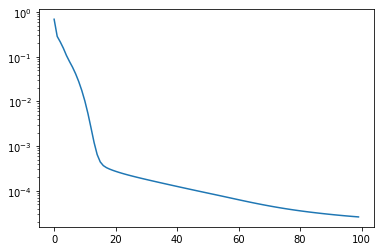

In [ ]:
plt.semilogy(loss_list)

In [ ]:
q_list = []
p_list = []
x0 = Q[27,0]
y0 = P[27,0]
q_list.append(x0)
p_list.append(y0)
for i in range(2500):
  inp = tf.convert_to_tensor(np.array([[[x0,y0]]]))
  out = model.call(inp).numpy()
  x0 = out[0,0,0]
  y0 = out[0,0,1]
  q_list.append(x0)
  p_list.append(y0)



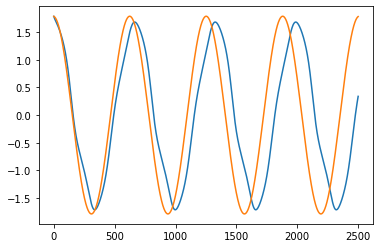

In [ ]:
plt.plot(q_list)
plt.plot(Q[27])

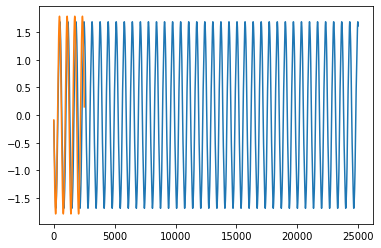

In [ ]:
plt.plot(p_list)
plt.plot(P[27])

Text(0, 0.5, 'p')

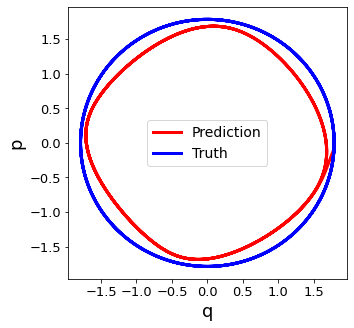

In [ ]:
plt.figure(figsize = (5,5))
plt.plot(q_list, p_list,'r', linewidth = 3)
plt.plot(Q[27], P[27],'b',linewidth = 3)
plt.legend(['Prediction','Truth'], fontsize =14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel('q', fontsize = 18)
plt.ylabel('p', fontsize = 18)

In [ ]:
l2 = np.sqrt(np.sum((np.array(q_list) - Q[27])**2 + np.array(p_list -P[27])**2))
l2or = np.sqrt(np.sum((Q[27])**2 + np.array(P[27])**2))
print(l2)
print(l2/l2or)

65.71349589843562
0.7346033430480218


In [ ]:
fig, ax = plt.subplots(5,3, figsize = (16,9),gridspec_kw={'width_ratios': [3,3,1]})
relative_l2 = []
for i in range(5):
  q = Q[25+i,:]
  p = P[25+i,:]
  sol = solve_ivp(gradient_function,[0,25],[q[0], p[0]], t_eval = np.linspace(0,25,2501))
  #plt.figure()
  ax[i,0].plot(q,'--r')
  ax[i,0].plot(sol['y'][0,:],'b')
  #plt.figure()
  ax[i,1].plot(p,'--r')
  ax[i,1].plot(sol['y'][1,:],'b')
  #plt.figure()
  ax[i,2].plot(q,p)
  ax[i,2].plot(sol['y'][0,:],sol['y'][1,:],'--r')
  l2 = np.sqrt(np.sum((sol['y'][0,:] - q)**2 + (sol['y'][0,:] - q)**2))
  l2or = np.sqrt(np.sum((Q[27])**2 + np.array(P[27])**2))
  relative_l2.append(l2/l2or)

## 3 body problem

In [ ]:
class planet:
  def __init__(self, position, momentum, mass):
    self.position = position
    self.momentum = momentum
    self.mass = mass

  def drdt(self):
    drdt = self.momentum/self.mass
    return drdt


def dpdt(planet1, planet2):
  m1 = planet1.mass
  m2 = planet2.mass
  r1 = planet1.position
  r2 = planet2.position
  drdt = g* m1*m2 * ( r1-r2) / np.linalg.norm(r1-r2)**1.5
  return drdt

In [ ]:
def Hamiltonian_3body(t,inp):

  m1 = m2 = m3 = 1

  r1 = np.array([inp[0], inp[1]])
  p1 = np.array([inp[2], inp[3]])

  r2 = np.array([inp[4], inp[5]])
  p2 = np.array([inp[6], inp[7]])
  
  r3 = np.array([inp[8], inp[9]])
  p3 = np.array([inp[10], inp[11]])

  planet1 = planet(r1, p1, m1)
  planet2 = planet(r2, p2, m2)
  planet3 = planet(r3, p3, m3)

  dr1dt = planet1.drdt()
  dr2dt = planet2.drdt()
  dr3dt = planet3.drdt()

  dp1dt = -1* (dpdt(planet1, planet2) + dpdt(planet1, planet3))
  dp2dt = -1* (dpdt(planet2, planet1) + dpdt(planet2, planet3))
  dp3dt = -1* (dpdt(planet3, planet1) + dpdt(planet3, planet2))

  return np.concatenate((dr1dt, dp1dt, dr2dt, dp2dt, dr3dt, dp3dt))

In [ ]:
def rotation(x, theta):
  c = np.cos(theta)
  s = np.sin(theta)
  rotation_matrix = np.array([[c, -s], [s, c]])
  rotated = np.matmul(rotation_matrix, x)
  return np.squeeze(rotated)

  
def get_initial_cond():
  '''The code for this function is from Greydanus et al.'''
  min_radius = 0.9
  max_radius = 1.2
  nu = 2e-1
  p1 = 2*np.random.rand(2) - 1
  r = np.random.rand() * (max_radius-min_radius) + min_radius

  p1 *= r/np.sqrt( np.sum((p1**2)) )
  p2 = rotation(p1, theta=2*np.pi/3)
  p3 = rotation(p2, theta=2*np.pi/3)

  # # velocity that yields a circular orbit
  v1 = rotation(p1, theta=np.pi/2)
  v1 = v1 / r**1.5
  v1 = v1 * np.sqrt(np.sin(np.pi/3)/(2*np.cos(np.pi/6)**2)) # scale factor to get circular trajectories
  v2 = rotation(v1, theta=2*np.pi/3)
  v3 = rotation(v2, theta=2*np.pi/3)

  # make the circular orbits slightly chaotic
  v1 *= 1 + nu*(2*np.random.rand(2) - 1)
  v2 *= 1 + nu*(2*np.random.rand(2) - 1)
  v3 *= 1 + nu*(2*np.random.rand(2) - 1)

  initial_cond = np.concatenate((p1, v1, p2, v2, p3, v3))
  return initial_cond

In [ ]:
three_body_data = np.zeros((30, 12, 301))
g = 1

for i in range(30):
  initial_cond = get_initial_cond()
  sol = solve_ivp(Hamiltonian_3body, [0,3], initial_cond, t_eval = np.linspace(0,3,301))
  three_body_data[i,:,:] = sol['y']

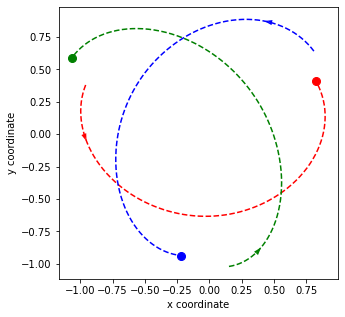

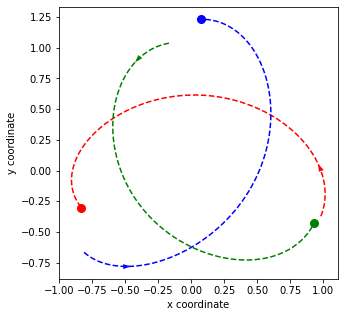

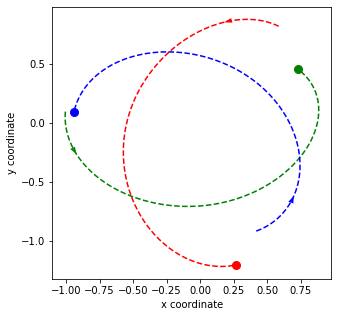

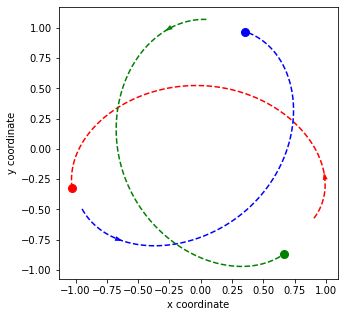

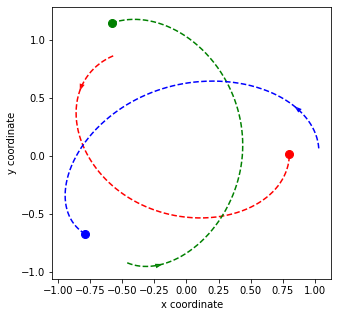

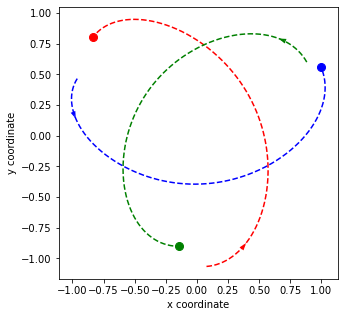

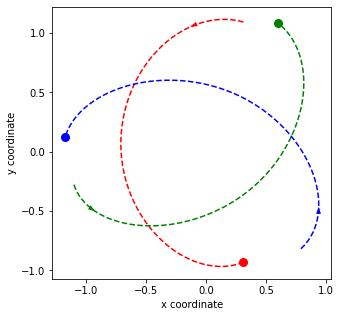

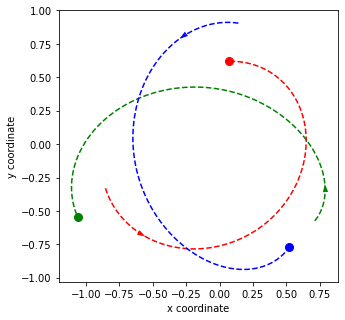

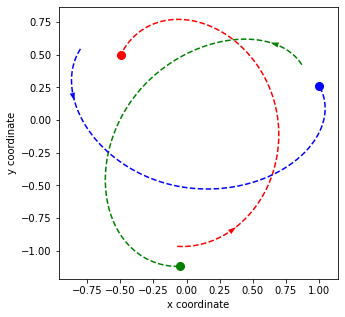

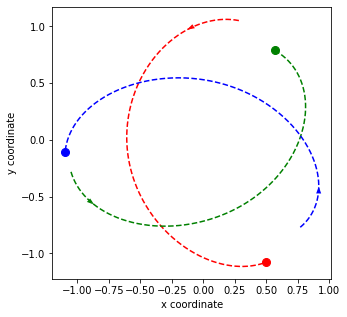

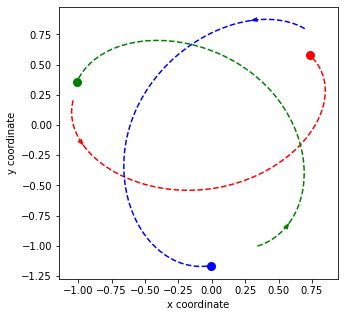

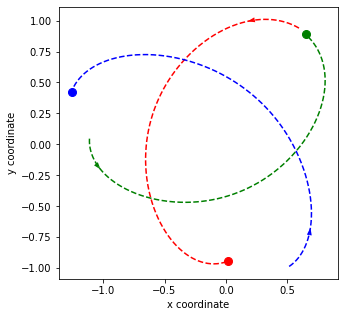

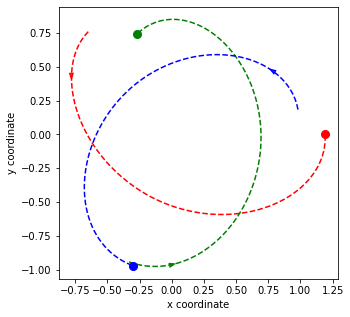

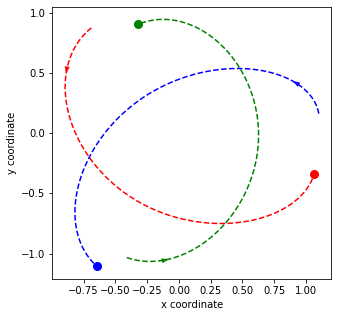

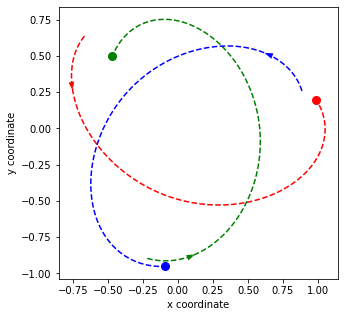

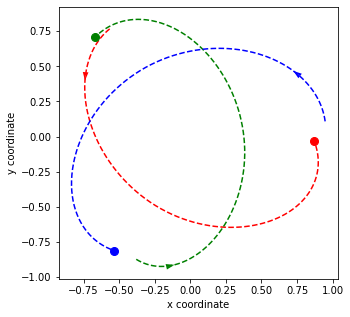

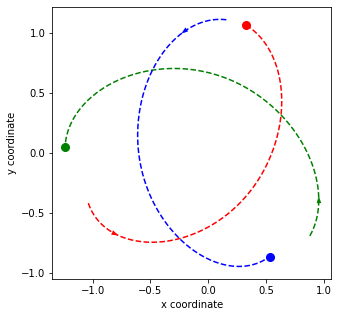

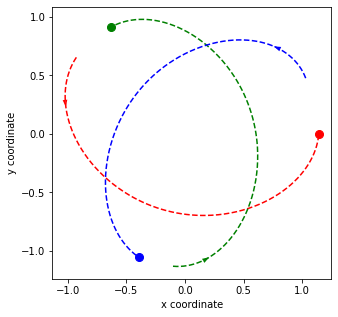

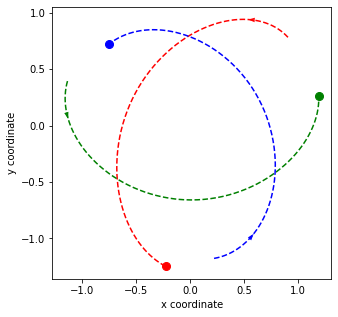

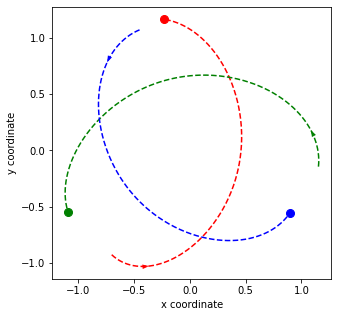

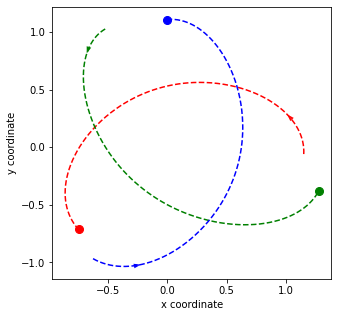

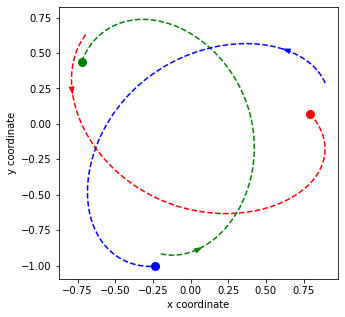

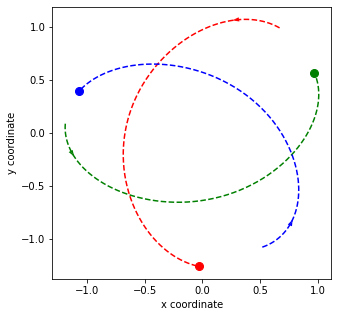

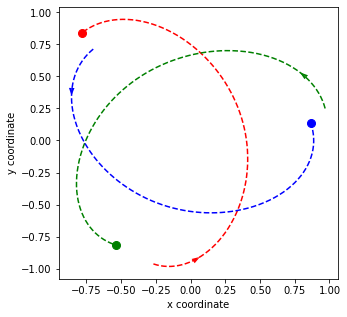

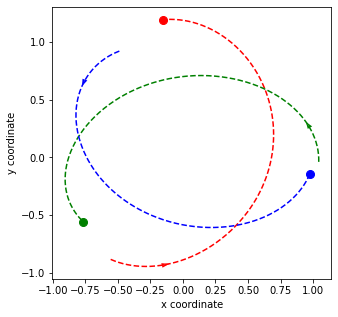

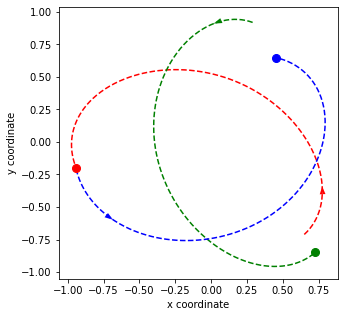

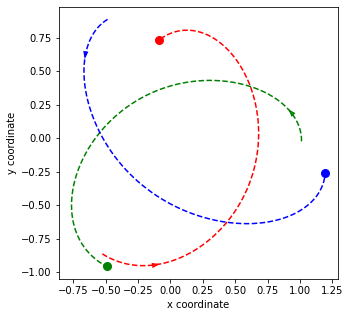

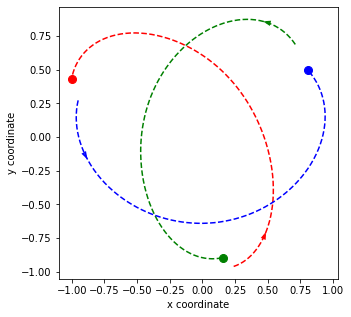

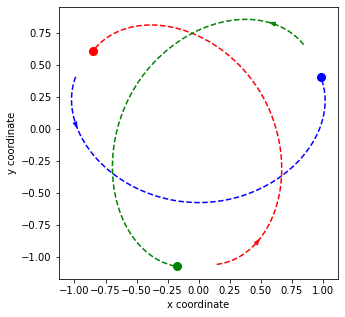

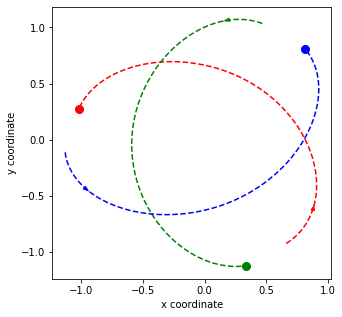

In [ ]:
for i in range(30):
  plt.figure(figsize = (5,5))
  plt.plot(three_body_data[i,0,:],three_body_data[i,1,:],'--r')
  plt.plot(three_body_data[i,4,:],three_body_data[i,5,:],'--g')
  plt.plot(three_body_data[i,8,:],three_body_data[i,9,:],'--b')
  plt.plot(three_body_data[i,0,-1],three_body_data[i,1,-1],'or', markersize= 8)
  plt.plot(three_body_data[i,4,-1],three_body_data[i,5,-1],'og', markersize= 8)
  plt.plot(three_body_data[i,8,-1],three_body_data[i,9,-1],'ob', markersize= 8)
  plt.arrow(three_body_data[i,0,50],three_body_data[i,1,50], three_body_data[i,0,51] - three_body_data[i,0,50], three_body_data[i,1,51]-three_body_data[i,1,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'r')
  plt.arrow(three_body_data[i,4,40],three_body_data[i,5,40], three_body_data[i,4,41] - three_body_data[i,4,40], three_body_data[i,5,41]-three_body_data[i,5,40], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'g')
  plt.arrow(three_body_data[i,8,50],three_body_data[i,9,50], three_body_data[i,8,51] - three_body_data[i,8,50], three_body_data[i,9,51]-three_body_data[i,9,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'b')
  plt.xlabel('x coordinate')
  plt.ylabel('y coordinate')
  plt.show()

In [ ]:
inputs = three_body_data[:25,:,:]
print(inputs.shape)
inputs = np.transpose(inputs, (0,2,1)).reshape(-1,12)
print(inputs.shape)
inputs = tf.convert_to_tensor(inputs)

(25, 12, 301)
(7525, 12)


In [ ]:
derivs = np.zeros((25,12,301))
for i in range(25):
  for j in range(301):
    rate_of_change= Hamiltonian_3body(1,three_body_data[i,:,j])
    derivs[i,0:2,j] = -rate_of_change[2:4]
    derivs[i,2:4,j] =  rate_of_change[0:2]
    derivs[i,4:6,j] = -rate_of_change[6:8]
    derivs[i,6:8,j] =  rate_of_change[4:6]
    derivs[i,8:10,j]= -rate_of_change[10:12]
    derivs[i,10:12,j]= rate_of_change[8:10]

derivs = np.transpose(derivs, (0,2,1)).reshape(-1,12)
print(derivs.shape)
derivs = tf.convert_to_tensor(derivs)

(7525, 12)


In [ ]:
class Hamiltonian(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(200, activation ='tanh')
    self.dense2 = tf.keras.layers.Dense(200, activation ='tanh')
    self.dense3 = tf.keras.layers.Dense(12, use_bias = False)

  def hamilt_net(self,inputs):
    x = inputs
    x = self.dense1(x)
    x = self.dense2(x)
    output = self.dense3(x)
    return output

  def call(self,inputs):
    with tf.GradientTape() as tape:
      tape.watch(inputs)
      y_pred = self.hamilt_net(inputs)
    derivatives = tape.gradient(y_pred, inputs)
    return derivatives

  def loss(self, predictions, labels):
    loss = tf.reduce_mean((predictions - labels)**2)
    return loss
  

In [ ]:
model = Hamiltonian()
input = tf.random.normal([1,12]) #batch_sz, window_sz, num_features
output = model(input)
model.summary()

Model: "hamiltonian_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            multiple                  2600      
                                                                 
 dense_24 (Dense)            multiple                  40200     
                                                                 
 dense_25 (Dense)            multiple                  2400      
                                                                 
Total params: 45,200
Trainable params: 45,200
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_hamiltonian = Hamiltonian()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

num_epochs = 200
batch_size = 512
num_batches = inputs.shape[0]//batch_size
for i in range(num_epochs):
  batch_loss = []   
  for j in range(num_batches):
    start = j*batch_size
    end   = (j+1)*batch_size
    with tf.GradientTape() as tape:
      y_pred = model_hamiltonian.call(inputs[start:end,:])
      loss = model_hamiltonian.loss(y_pred, derivs[start:end,:])
    
    gradients = tape.gradient(loss, model_hamiltonian.trainable_variables)
    #print(gradients)
    optimizer.apply_gradients(zip(gradients, model_hamiltonian.trainable_variables))
    batch_loss.append(loss)
  if i % 10 == 0:
    print(f"Loss on training set after {i} training steps: {sum(batch_loss)/len(batch_loss)}")

Loss on training set after 0 training steps: 0.9143672575204931
Loss on training set after 10 training steps: 0.05268818731427213
Loss on training set after 20 training steps: 0.0298488070825729
Loss on training set after 30 training steps: 0.007389200050135843
Loss on training set after 40 training steps: 0.0038425084421969532
Loss on training set after 50 training steps: 0.002827974598575966
Loss on training set after 60 training steps: 0.002295404616848728
Loss on training set after 70 training steps: 0.002005329953262501
Loss on training set after 80 training steps: 0.0018697103988210791
Loss on training set after 90 training steps: 0.0016851030855265755
Loss on training set after 100 training steps: 0.0015365164615016769
Loss on training set after 110 training steps: 0.0032999450875815487
Loss on training set after 120 training steps: 0.0017502764672074154
Loss on training set after 130 training steps: 0.0011081190138092043
Loss on training set after 140 training steps: 0.00100395

In [ ]:
def gradient_function(t, x):
  #print(x)
  #print(t)
  inputs = tf.reshape(tf.convert_to_tensor(x),[-1,12])
  deriv = model_hamiltonian.call(inputs).numpy()
  #print(deriv)
  out = np.zeros(12)
  out[0:2] =  deriv[0,2:4]
  out[2:4] = -deriv[0,0:2]
  out[4:6] =  deriv[0,6:8]
  out[6:8] = -deriv[0,4:6]
  out[8:10]=  deriv[0,10:12]
  out[10:12]=-deriv[0,8:10]

  return out

(12, 301)


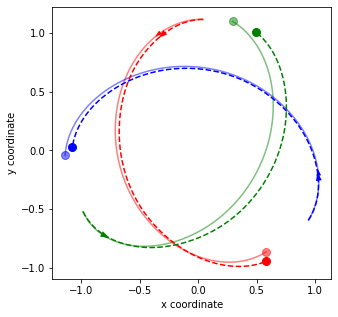

(12, 301)


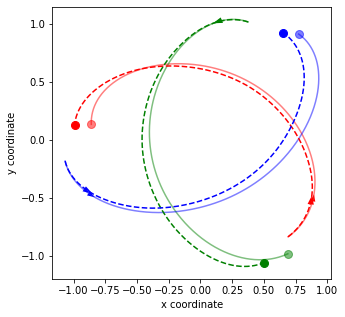

(12, 301)


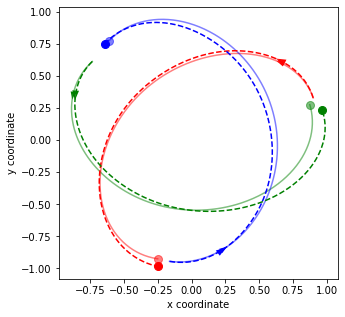

(12, 301)


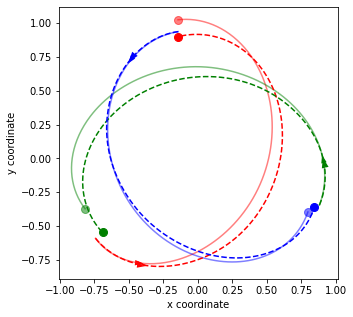

(12, 301)


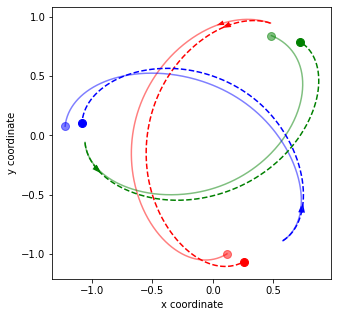

In [ ]:
i =28
l2_list = []
for i in range(25,30):
  init_value =  three_body_data[i,:,0]
  sol = solve_ivp(gradient_function, [0,3], init_value, t_eval = np.linspace(0,3,301))
  print(sol['y'].shape)

  plt.figure(figsize = (5,5))
  plt.plot(three_body_data[i,0,:],three_body_data[i,1,:],'-r', alpha = 0.5)
  plt.plot(three_body_data[i,4,:],three_body_data[i,5,:],'-g',alpha = 0.5)
  plt.plot(three_body_data[i,8,:],three_body_data[i,9,:],'-b',alpha = 0.5)
  plt.plot(three_body_data[i,0,-1],three_body_data[i,1,-1],'or', markersize= 8,alpha = 0.5)
  plt.plot(three_body_data[i,4,-1],three_body_data[i,5,-1],'og', markersize= 8,alpha = 0.5)
  plt.plot(three_body_data[i,8,-1],three_body_data[i,9,-1],'ob', markersize= 8,alpha = 0.5)
  plt.arrow(three_body_data[i,0,50],three_body_data[i,1,50], three_body_data[i,0,51] - three_body_data[i,0,50], three_body_data[i,1,51]-three_body_data[i,1,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'r')
  plt.arrow(three_body_data[i,4,40],three_body_data[i,5,40], three_body_data[i,4,41] - three_body_data[i,4,40], three_body_data[i,5,41]-three_body_data[i,5,40], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'g')
  plt.arrow(three_body_data[i,8,50],three_body_data[i,9,50], three_body_data[i,8,51] - three_body_data[i,8,50], three_body_data[i,9,51]-three_body_data[i,9,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'b')

  plt.plot(sol['y'][0,:],sol['y'][1,:],'--r')
  plt.plot(sol['y'][4,:],sol['y'][5,:],'--g')
  plt.plot(sol['y'][8,:],sol['y'][9,:],'--b')
  plt.plot(sol['y'][0,-1],sol['y'][1,-1],'or', markersize= 8)
  plt.plot(sol['y'][4,-1],sol['y'][5,-1],'og', markersize= 8)
  plt.plot(sol['y'][8,-1],sol['y'][9,-1],'ob', markersize= 8)
  plt.arrow(sol['y'][0,50],sol['y'][1,50], sol['y'][0,51] - sol['y'][0,50], sol['y'][1,51]-sol['y'][1,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.05,color = 'r')
  plt.arrow(sol['y'][4,40],sol['y'][5,40], sol['y'][4,41] - sol['y'][4,40], sol['y'][5,41]-sol['y'][5,40], shape = 'full',lw=0, length_includes_head=True, head_width=0.05,color = 'g')
  plt.arrow(sol['y'][8,50],sol['y'][9,50], sol['y'][8,51] - sol['y'][8,50], sol['y'][9,51]-sol['y'][9,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.05,color = 'b')

  l2 = np.sqrt(np.sum((three_body_data[i:i+1,:,:] - sol['y'])**2))
  l2_or = np.sqrt(np.sum((three_body_data[i:i+1,:,:])**2))
  l2_list.append(l2/l2_or)
  plt.xlabel('x coordinate')
  plt.ylabel('y coordinate')
  plt.show()

In [ ]:
l2_list

[0.07147165798494912,
 0.06828620970048767,
 0.06010084987272587,
 0.07926046372280413,
 0.09350982791041434]

In [ ]:
np.mean(l2_list)

0.07452580183827623

### Multistep neural networks

In [ ]:
xn_1 = np.zeros((25*300,12))
xn   = np.zeros((25*300,12))

for i in range(25):
  start = i*300
  end   = (i+1)*300
  xn_1[start:end,:] = three_body_data[i,:,:300].T
  xn[start:end,:]   = three_body_data[i,:,1:].T

xn_1 = tf.convert_to_tensor(xn_1, dtype = tf.float32)
xn   = tf.convert_to_tensor(xn,   dtype = tf.float32)

In [ ]:
class MultiStepNN(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(200, activation ='tanh')
    self.dense2 = tf.keras.layers.Dense(200, activation ='tanh')
    self.dense3 = tf.keras.layers.Dense(12)

  def call(self,inputs):
    x = inputs
    x = self.dense1(x)
    #x = self.dense2(x)
    output = self.dense3(x)
    return output

  def loss(self, xn_1, xn, fxn_1, fxn):
    dt = 1e-2
    loss = tf.reduce_mean(tf.reduce_sum((xn_1 - xn + 0.5* dt * (fxn_1 + fxn))**2, axis = 1))
    #loss =  tf.reduce_mean((tf.reduce_sum(inputs_processed, axis = 1) + 0.5*dt*tf.reduce_sum(predictions, axis =1))**2)
    return loss

In [ ]:
model_multistep = MultiStepNN()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
num_epochs = 200
batch_size = 512
num_batches = xn.shape[0]//batch_size
loss_list = []
for i in range(num_epochs):
  batch_loss = []   
  for j in range(num_batches):
    start = j*batch_size
    end   = (j+1)*batch_size
    with tf.GradientTape() as tape:
      y_pred_1 = model_multistep.call(xn_1[start:end,:])
      y_pred   = model_multistep.call(xn[start:end,:])
      #print(y_pred)
      #print(lorentz_data_proc[start:end,:,:])
      loss = model_multistep.loss(xn_1[start:end,:], xn[start:end,:], y_pred_1, y_pred)
    
    gradients = tape.gradient(loss, model_multistep.trainable_variables)
    #print(gradients)
    optimizer.apply_gradients(zip(gradients, model_multistep.trainable_variables))
    batch_loss.append(loss)
  loss_list.append(sum(batch_loss)/len(batch_loss))
  if i % 10 == 0:
    print(f"Loss on training set after {i} training steps: {sum(batch_loss)/len(batch_loss)}")

Loss on training set after 0 training steps: 0.0007209376199170947
Loss on training set after 10 training steps: 3.364886651979759e-05
Loss on training set after 20 training steps: 3.247119457228109e-05
Loss on training set after 30 training steps: 3.145317532471381e-05
Loss on training set after 40 training steps: 3.0402867196244188e-05
Loss on training set after 50 training steps: 2.917079473263584e-05
Loss on training set after 60 training steps: 2.7597245207289234e-05
Loss on training set after 70 training steps: 2.5503413780825213e-05
Loss on training set after 80 training steps: 2.2745471142116003e-05
Loss on training set after 90 training steps: 1.934662213898264e-05
Loss on training set after 100 training steps: 1.56041332957102e-05
Loss on training set after 110 training steps: 1.2003438314422965e-05
Loss on training set after 120 training steps: 8.984046871773899e-06
Loss on training set after 130 training steps: 6.747147835994838e-06
Loss on training set after 140 training s

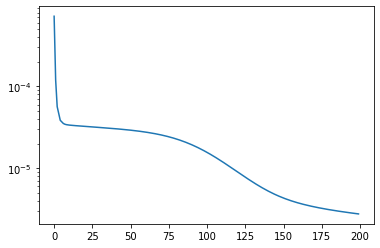

In [ ]:
plt.semilogy(loss_list)

In [ ]:
def gradient_function(t, x):
  #print(x)
  #print(t)
  inputs = tf.reshape(tf.convert_to_tensor(x),[-1,12])
  deriv = model_multistep.call(inputs).numpy()
  #print(deriv)
  out = deriv


  return out

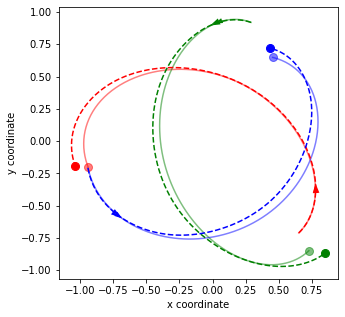

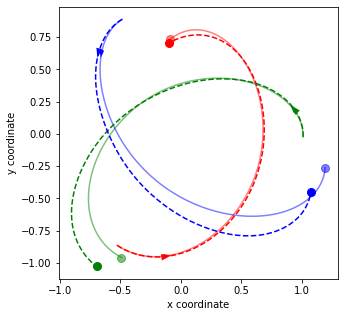

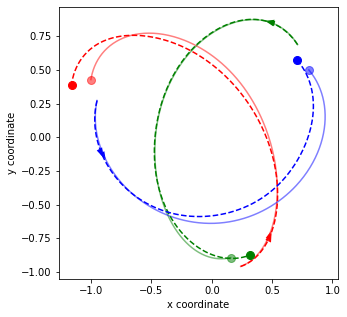

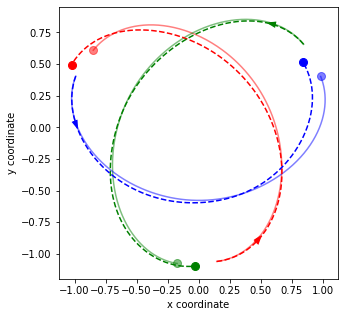

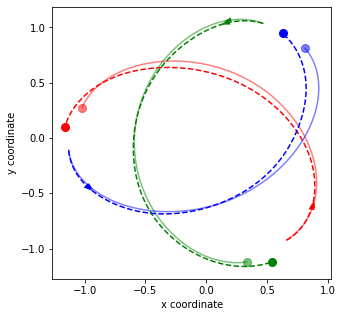

In [ ]:
l2_list = []
for i in range(25,30):
  init_value =  three_body_data[i,:,0]
  sol = solve_ivp(gradient_function, [0,3], init_value, t_eval = np.linspace(0,3,301))


  plt.figure(figsize = (5,5))
  plt.plot(three_body_data[i,0,:],three_body_data[i,1,:],'-r', alpha = 0.5)
  plt.plot(three_body_data[i,4,:],three_body_data[i,5,:],'-g',alpha = 0.5)
  plt.plot(three_body_data[i,8,:],three_body_data[i,9,:],'-b',alpha = 0.5)
  plt.plot(three_body_data[i,0,-1],three_body_data[i,1,-1],'or', markersize= 8,alpha = 0.5)
  plt.plot(three_body_data[i,4,-1],three_body_data[i,5,-1],'og', markersize= 8,alpha = 0.5)
  plt.plot(three_body_data[i,8,-1],three_body_data[i,9,-1],'ob', markersize= 8,alpha = 0.5)
  plt.arrow(three_body_data[i,0,50],three_body_data[i,1,50], three_body_data[i,0,51] - three_body_data[i,0,50], three_body_data[i,1,51]-three_body_data[i,1,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'r')
  plt.arrow(three_body_data[i,4,40],three_body_data[i,5,40], three_body_data[i,4,41] - three_body_data[i,4,40], three_body_data[i,5,41]-three_body_data[i,5,40], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'g')
  plt.arrow(three_body_data[i,8,50],three_body_data[i,9,50], three_body_data[i,8,51] - three_body_data[i,8,50], three_body_data[i,9,51]-three_body_data[i,9,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'b')

  plt.plot(sol['y'][0,:],sol['y'][1,:],'--r')
  plt.plot(sol['y'][4,:],sol['y'][5,:],'--g')
  plt.plot(sol['y'][8,:],sol['y'][9,:],'--b')
  plt.plot(sol['y'][0,-1],sol['y'][1,-1],'or', markersize= 8)
  plt.plot(sol['y'][4,-1],sol['y'][5,-1],'og', markersize= 8)
  plt.plot(sol['y'][8,-1],sol['y'][9,-1],'ob', markersize= 8)
  plt.arrow(sol['y'][0,50],sol['y'][1,50], sol['y'][0,51] - sol['y'][0,50], sol['y'][1,51]-sol['y'][1,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.05,color = 'r')
  plt.arrow(sol['y'][4,40],sol['y'][5,40], sol['y'][4,41] - sol['y'][4,40], sol['y'][5,41]-sol['y'][5,40], shape = 'full',lw=0, length_includes_head=True, head_width=0.05,color = 'g')
  plt.arrow(sol['y'][8,50],sol['y'][9,50], sol['y'][8,51] - sol['y'][8,50], sol['y'][9,51]-sol['y'][9,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.05,color = 'b')

  l2 = np.sqrt(np.sum((three_body_data[i:i+1,:,:] - sol['y'])**2))
  l2_or = np.sqrt(np.sum((three_body_data[i:i+1,:,:])**2))
  l2_list.append(l2/l2_or)

  plt.xlabel('x coordinate')
  plt.ylabel('y coordinate')
  plt.show()

In [ ]:
np.mean(l2_list)

0.08544084296765384

## Lorenz system

In [ ]:
def Lorenz(t,inp):
  x = inp[0]
  y = inp[1]
  z = inp[2]

  rho   = 28.
  sigma = 10.
  beta  = 8./3.

  dxdt = sigma*(y-x)
  dydt = x*(rho-z) - y
  dzdt = x*y - beta*z

  return [dxdt, dydt, dzdt]


In [ ]:
sol = solve_ivp(Lorenz, [0,50], [-8.0, 7.0, 27.0], t_eval = np.linspace(0,25,2501))

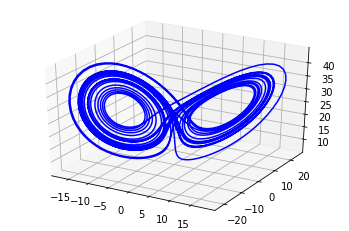

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(sol['y'][0,:], sol['y'][1,:], sol['y'][2,:], 'blue')

In [ ]:
lorenz_data = np.zeros((30,3,2501))
for i in range(30):
  x0 = np.random.random()*20 - 10
  y0 = np.random.random()*30 - 15
  z0 = np.random.random()*40
  sol = solve_ivp(Lorenz, [0,25], [x0, y0, z0], t_eval = np.linspace(0,25,2501))
  lorenz_data[i,:,:] = sol['y']
  

<ipython-input-9-811425dd7431>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (5,5))
<ipython-input-9-811425dd7431>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (5,5))
<ipython-input-9-811425dd7431>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(

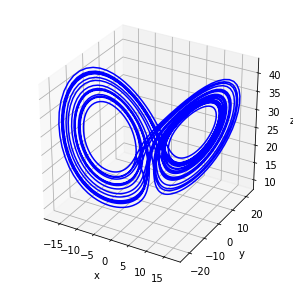

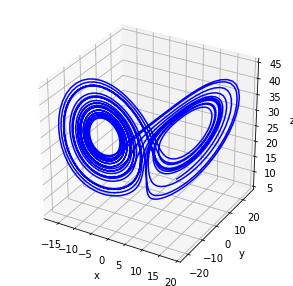

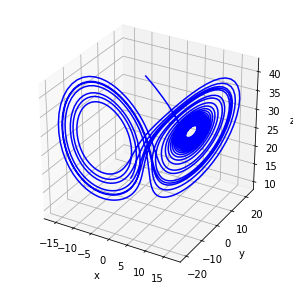

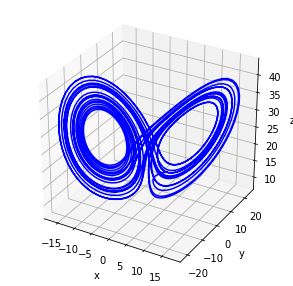

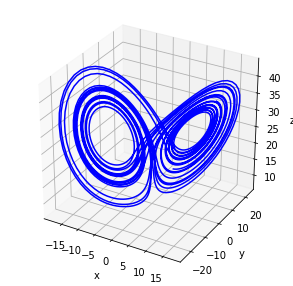

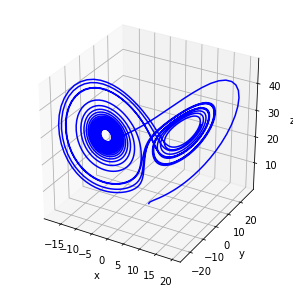

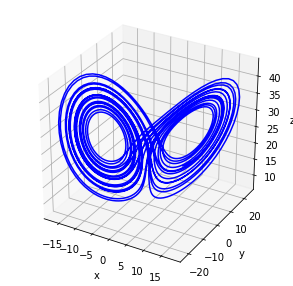

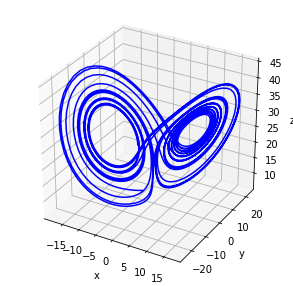

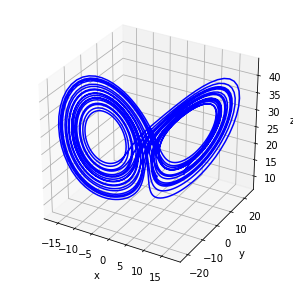

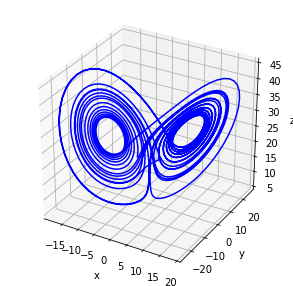

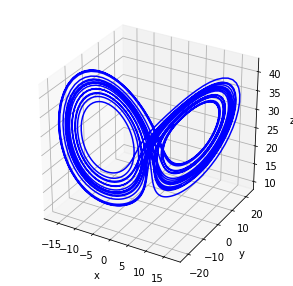

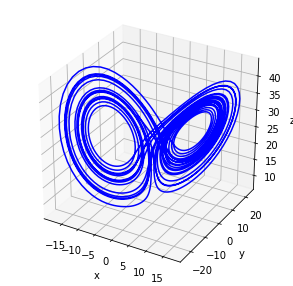

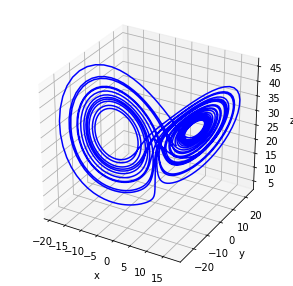

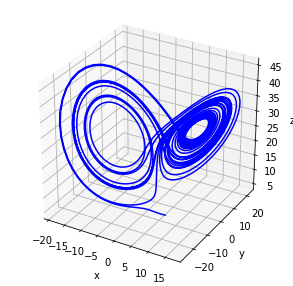

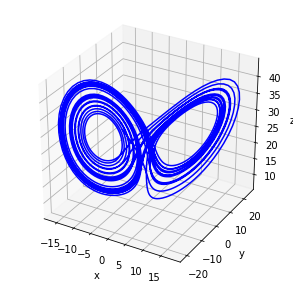

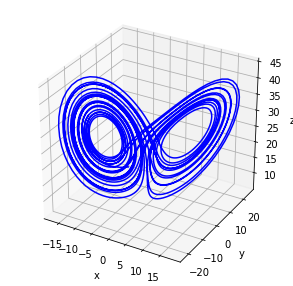

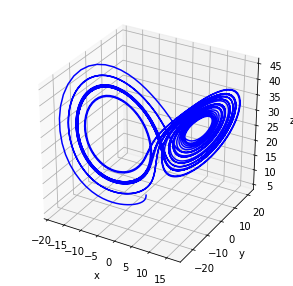

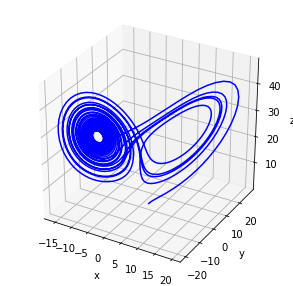

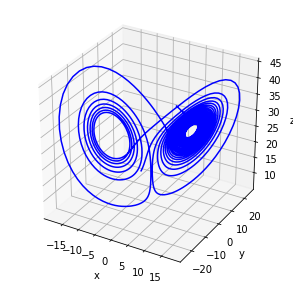

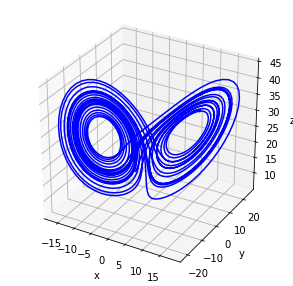

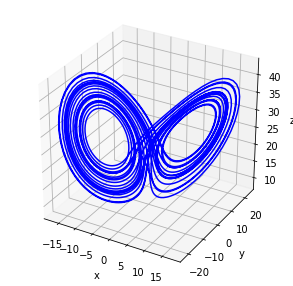

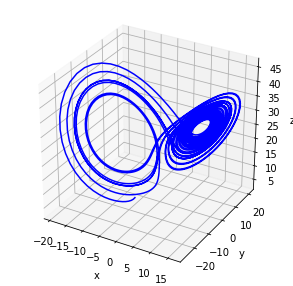

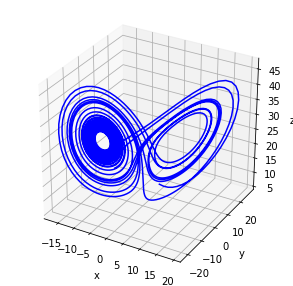

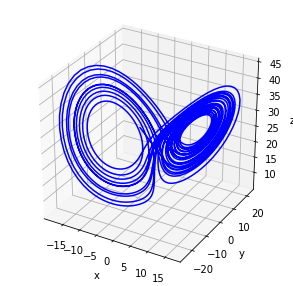

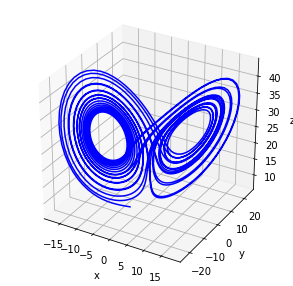

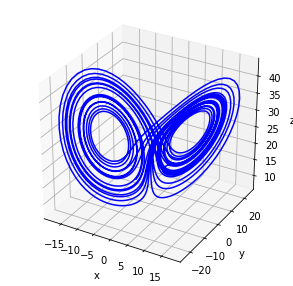

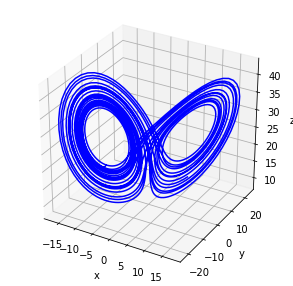

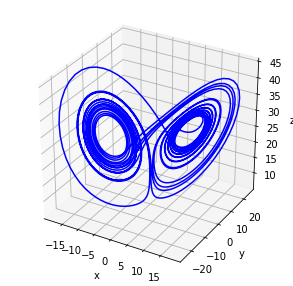

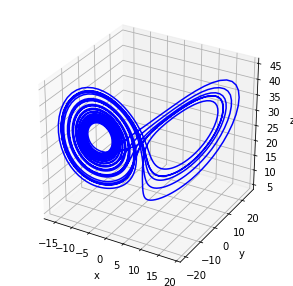

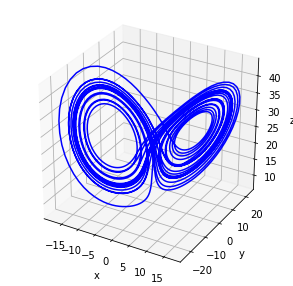

In [ ]:
for i in range(30):
  fig = plt.figure(figsize = (5,5))
  ax = plt.axes(projection='3d')
  ax.plot3D(lorenz_data[i,0,:],lorenz_data[i,1,:],lorenz_data[i,2,:], 'blue')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')

In [ ]:
lorenz_data.shape

(30, 3, 2501)

### Hamiltonian Neural Network

In [ ]:
derivs = np.zeros((30,3,2501))


In [ ]:
def Lorenz_der(t,inp):
  x = inp[0]
  y = inp[1]
  z = inp[2]
  xd= inp[3]
  yd= inp[4]
  zd= inp[5]

  rho   = 28.
  sigma = 10.
  beta  = 8./3.

  dxdt = sigma*(yd-xd)
  dydt = xd*(rho-z) -x*zd - yd
  dzdt = xd*y + x*yd - beta*zd

  return [-dxdt, -dydt, -dzdt]

In [ ]:
inp = np.zeros((30,6,2501))
inp[:,:3,:] = lorenz_data
t = 1
for i in range(30):
  for j in range(2501):
    x = lorenz_data[i,:,j]
    dxdt = Lorenz(t, x)
    inp[i,3:,j] = dxdt

In [ ]:
derivs = np.zeros((30,6,2501))
derivs[:,3:,:] = inp[:,3:,:]
for i in range(30):
  for j in range(2501):
    y = inp[i,:,j]
    dydt = Lorenz_der(t,y)
    derivs[i,:3,j] = dydt

In [ ]:

inps_train = np.transpose(inp[:25,:,:], (0,2,1)).reshape(-1,6)
derivs_train=np.transpose(derivs[:25,:,:], (0,2,1)).reshape(-1,6)

inp_max = np.max(inps_train, axis = 0)
inp_min = np.min(inps_train, axis = 0)

derivs_max = np.max(derivs_train, axis = 0)
derivs_min = np.min(derivs_train, axis = 0)

inps_train = (inps_train - inp_min)/(inp_max- inp_min)
derivs_train = (derivs_train -derivs_min)/(derivs_max - derivs_min)
print(inps_train.shape)
print(derivs_train.shape)

inps_train = tf.convert_to_tensor(inps_train)
derivs_train=tf.convert_to_tensor(derivs_train)

(62525, 6)
(62525, 6)


In [ ]:
max = np.max(inps_train, axis = 0)

In [ ]:
np.max(derivs_train, axis = 0)

array([1., 1., 1., 1., 1., 1.])

In [ ]:
class Hamiltonian(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(200, activation ='tanh')
    self.dense2 = tf.keras.layers.Dense(200, activation ='tanh')
    self.dense3 = tf.keras.layers.Dense(6, use_bias = False)

  def hamilt_net(self,inputs):
    x = inputs
    x = self.dense1(x)
    x = self.dense2(x)
    output = self.dense3(x)
    return output

  def call(self,inputs):
    with tf.GradientTape() as tape:
      tape.watch(inputs)
      y_pred = self.hamilt_net(inputs)
    derivatives = tape.gradient(y_pred, inputs)
    return derivatives

  def loss(self, predictions, labels):
    loss = tf.reduce_mean((predictions - labels)**2)
    return loss
  

In [ ]:
model_hamiltonian_lorenz = Hamiltonian()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

num_epochs = 1000
batch_size = 1024
num_batches = inps_train.shape[0]//batch_size
for i in range(num_epochs):
  batch_loss = []   
  for j in range(num_batches):
    start = j*batch_size
    end   = (j+1)*batch_size
    with tf.GradientTape() as tape:
      y_pred = model_hamiltonian_lorenz.call(inps_train[start:end,:])
      loss = model_hamiltonian_lorenz.loss(y_pred, derivs_train[start:end,:])
    
    gradients = tape.gradient(loss, model_hamiltonian_lorenz.trainable_variables)
    #print(gradients)
    optimizer.apply_gradients(zip(gradients, model_hamiltonian_lorenz.trainable_variables))
    batch_loss.append(loss)
  if i % 10 == 0:
    print(f"Loss on training set after {i} training steps: {sum(batch_loss)/len(batch_loss)}")

Loss on training set after 0 training steps: 0.0187402936104743
Loss on training set after 10 training steps: 0.0023251628028144625
Loss on training set after 20 training steps: 0.001960904022768945
Loss on training set after 30 training steps: 0.0016064269694319954
Loss on training set after 40 training steps: 0.0014140417800343644
Loss on training set after 50 training steps: 0.0009044091728120572
Loss on training set after 60 training steps: 0.0007885589518813617
Loss on training set after 70 training steps: 0.000722116286904617
Loss on training set after 80 training steps: 0.000666220774195893
Loss on training set after 90 training steps: 0.0006456263606911636
Loss on training set after 100 training steps: 0.0005985606280454709
Loss on training set after 110 training steps: 0.0005886034482467031
Loss on training set after 120 training steps: 0.0005391612667243404
Loss on training set after 130 training steps: 0.0005335269219990318
Loss on training set after 140 training steps: 0.00

In [ ]:
def gradient_function(t, x):
  #print(x)
  #print(t)
  x  = (x - inp_min)/(inp_max - inp_min)
  inputs = tf.reshape(tf.convert_to_tensor(x),[-1,6])
  deriv = model_hamiltonian_lorenz.call(inputs).numpy()
  deriv  = deriv*(derivs_max - derivs_min) + derivs_min
  #print(deriv)
  out = np.zeros(6)
  out[:3] =  deriv[0,3:]
  out[3:] = -deriv[0,:3]
  return out

In [ ]:
i = 1000
model.call(inps_train[i:i+1,:])

NameError: ignored

In [ ]:
inps_train[i:i+1,:]

<tf.Tensor: shape=(1, 6), dtype=float64, numpy=
array([[0.4788284 , 0.47269824, 0.25888714, 0.53040427, 0.51504863,
        0.24398646]])>

In [ ]:
derivs_train[i:i+1,:]

<tf.Tensor: shape=(1, 6), dtype=float64, numpy=
array([[0.54758891, 0.47388534, 0.34645728, 0.53040427, 0.51504863,
        0.24398646]])>

ValueError: ignored

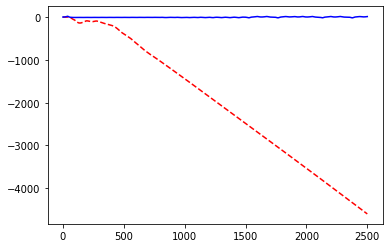

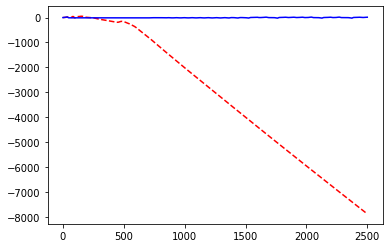

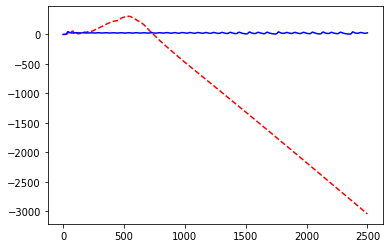

In [ ]:
l2_list = []
for i in range(5,10):
  ini_cond = inp[i, :, 0]
  sol = solve_ivp(gradient_function, [0,25], ini_cond, t_eval = np.linspace(0,25,2501))
  #sol_true = solve_ivp(Lorenz, [0,25], ini_cond, t_eval = np.linspace(0,25,2501))
  plt.figure()
  plt.plot(sol['y'][0,:],'--r')
  plt.plot(lorenz_data[i,0,:],'b')

  plt.figure()
  plt.plot(sol['y'][1,:],'--r')
  plt.plot(lorenz_data[i,1,:],'b')

  plt.figure()
  plt.plot(sol['y'][2,:],'--r')
  plt.plot(lorenz_data[i,2,:],'b')
  l2 = np.sqrt(np.sum((lorenz_data[25+i:25+i+1,:,:] - sol['y'])**2))
  l2_or = np.sqrt(np.sum((lorenz_data[25+i:25+i+1,:,:])**2))
  l2_list.append(l2/l2_or)

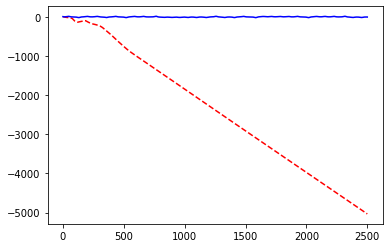

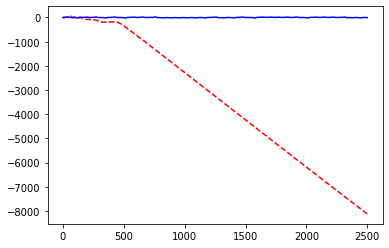

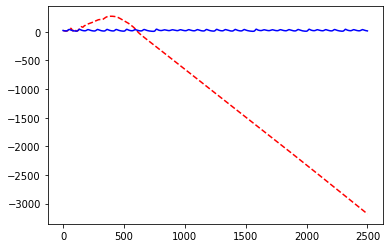

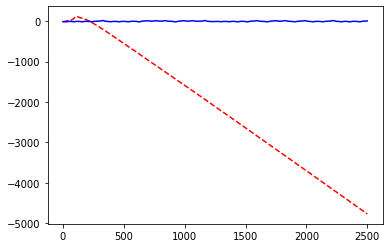

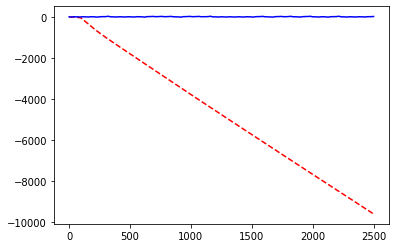

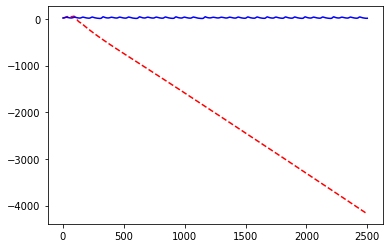

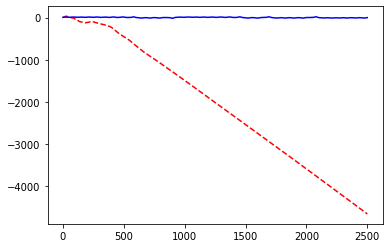

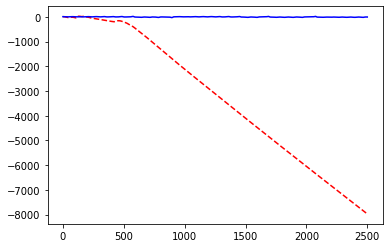

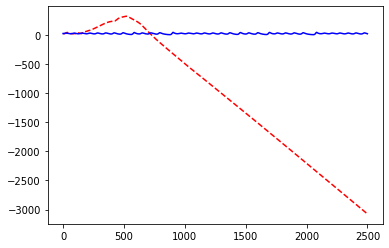

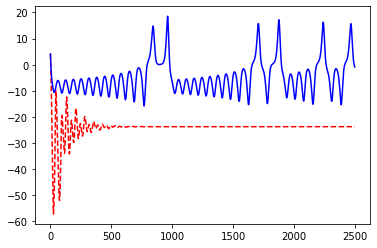

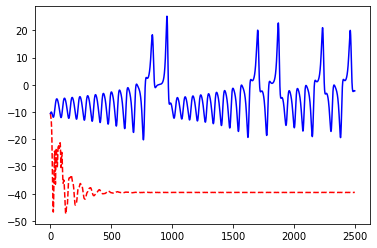

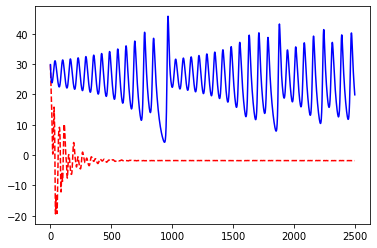

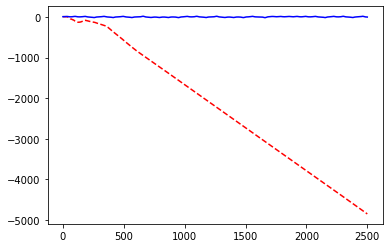

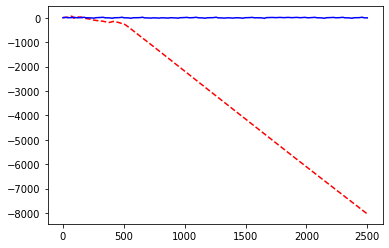

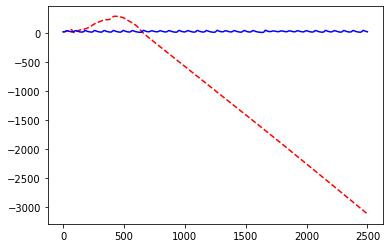

In [ ]:
l2_list = []
for i in range(5):
  ini_cond = inp[25+i, :, 0]
  sol = solve_ivp(gradient_function, [0,25], ini_cond, t_eval = np.linspace(0,25,2501))
  #sol_true = solve_ivp(Lorenz, [0,25], ini_cond, t_eval = np.linspace(0,25,2501))
  plt.figure()
  plt.plot(sol['y'][0,:],'--r')
  plt.plot(lorenz_data[25+i,0,:],'b')

  plt.figure()
  plt.plot(sol['y'][1,:],'--r')
  plt.plot(lorenz_data[25+i,1,:],'b')

  plt.figure()
  plt.plot(sol['y'][2,:],'--r')
  plt.plot(lorenz_data[25+i,2,:],'b')
  l2 = np.sqrt(np.sum((lorenz_data[25+i,:,:] - sol['y'][:3,:])**2))
  l2_or = np.sqrt(np.sum((lorenz_data[25+i,:,:])**2))
  l2_list.append(l2/l2_or)

In [ ]:
np.mean(l2_list)

160.27781268067434

### Multistep Neural Network

In [ ]:
xn_1 = np.zeros((25*2500,3))
xn   = np.zeros((25*2500,3))

for i in range(25):
  start = i*2500
  end   = (i+1)*2500
  xn_1[start:end,:] = lorenz_data[i,:,:2500].T
  xn[start:end,:]   = lorenz_data[i,:,1:].T

xn_1 = tf.convert_to_tensor(xn_1, dtype = tf.float32)
xn   = tf.convert_to_tensor(xn,   dtype = tf.float32)

In [ ]:
class MultiStepNN(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(200, activation ='tanh')
    #self.dense2 = tf.keras.layers.Dense(200, activation ='tanh')
    self.dense3 = tf.keras.layers.Dense(3)

  def call(self,inputs):
    x = inputs
    x = self.dense1(x)
    #x = self.dense2(x)
    output = self.dense3(x)
    return output

  def loss(self, xn_1, xn, fxn_1, fxn):
    dt = 1e-2
    loss = tf.reduce_mean(tf.reduce_sum((xn_1 - xn + 0.5* dt * (fxn_1 + fxn))**2, axis = 1))
    #loss =  tf.reduce_mean((tf.reduce_sum(inputs_processed, axis = 1) + 0.5*dt*tf.reduce_sum(predictions, axis =1))**2)
    return loss

In [ ]:
model = MultiStepNN()
input = tf.random.normal([1,3]) #batch_sz, window_sz, num_features
output = model(input)
model.summary()

Model: "multi_step_nn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            multiple                  800       
                                                                 
 dense_33 (Dense)            multiple                  603       
                                                                 
Total params: 1,403
Trainable params: 1,403
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lorenz_multistep = MultiStepNN()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
num_epochs = 1000
batch_size = 1024
num_batches = xn.shape[0]//batch_size
loss_list = []
for i in range(num_epochs):
  batch_loss = []   
  for j in range(num_batches):
    start = j*batch_size
    end   = (j+1)*batch_size
    with tf.GradientTape() as tape:
      y_pred_1 = model_lorenz_multistep.call(xn_1[start:end,:])
      y_pred   = model_lorenz_multistep.call(xn[start:end,:])
      #print(y_pred)
      #print(lorentz_data_proc[start:end,:,:])
      loss = model_lorenz_multistep.loss(xn_1[start:end,:], xn[start:end,:], y_pred_1, y_pred)
    
    gradients = tape.gradient(loss, model_lorenz_multistep.trainable_variables)
    #print(gradients)
    optimizer.apply_gradients(zip(gradients, model_lorenz_multistep.trainable_variables))
    batch_loss.append(loss)
  loss_list.append(sum(batch_loss)/len(batch_loss))
  if i % 10 == 0:
    print(f"Loss on training set after {i} training steps: {sum(batch_loss)/len(batch_loss)}")

Loss on training set after 0 training steps: 1.0658005475997925
Loss on training set after 10 training steps: 0.527012825012207
Loss on training set after 20 training steps: 0.3133794367313385
Loss on training set after 30 training steps: 0.20459266006946564
Loss on training set after 40 training steps: 0.1424776166677475
Loss on training set after 50 training steps: 0.1043677106499672
Loss on training set after 60 training steps: 0.08007815480232239
Loss on training set after 70 training steps: 0.0631265789270401
Loss on training set after 80 training steps: 0.05020713806152344
Loss on training set after 90 training steps: 0.039840467274188995
Loss on training set after 100 training steps: 0.03156929090619087
Loss on training set after 110 training steps: 0.025362402200698853
Loss on training set after 120 training steps: 0.020772704854607582
Loss on training set after 130 training steps: 0.01721942611038685
Loss on training set after 140 training steps: 0.01445857621729374
Loss on tr

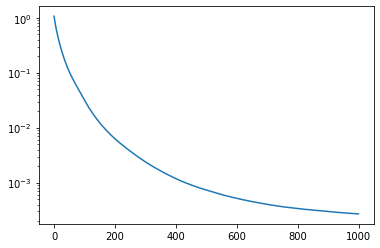

In [ ]:
plt.semilogy(loss_list)

In [ ]:
def gradient_function(t,x):
  id = np.array([1,1,1])
  x = np.vstack([x,id])
  inp = tf.convert_to_tensor(x[np.newaxis,:,:])
  #print(inp.shape)
  deriv = model_lorenz_multistep.call(inp).numpy()
  out = deriv[0,0,:]
  return out

In [ ]:
sol = solve_ivp(gradient_function, [0,25], [-8.0, 7.0, 27.0], t_eval = np.linspace(0,25,2501))
sol_true = solve_ivp(Lorenz, [0,25], [-8.0, 7.0, 27.0], t_eval = np.linspace(0,25,2501))

KeyboardInterrupt: ignored

NameError: ignored

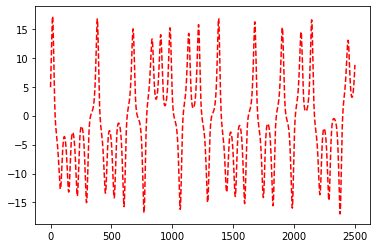

In [ ]:
plt.plot(sol['y'][0,:],'--r')
plt.plot(sol_true['y'][0,:],'b')

plt.figure()
plt.plot(sol['y'][1,:],'--r')
plt.plot(sol_true['y'][1,:],'b')

plt.figure()
plt.plot(sol['y'][2,:],'--r')
plt.plot(sol_true['y'][2,:],'b')

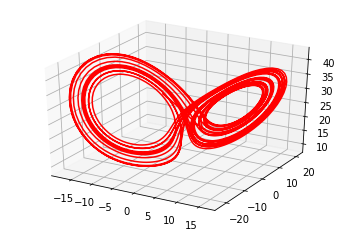

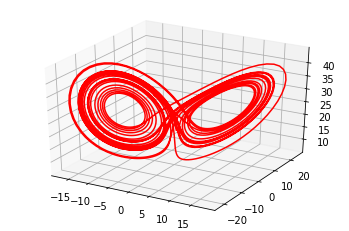

In [ ]:
fig = plt.figure ()
ax = plt.axes(projection='3d')
ax.plot3D(sol['y'][0,:], sol['y'][1,:], sol['y'][2,:], 'red')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(sol_true['y'][0,:], sol_true['y'][1,:], sol_true['y'][2,:], 'red')

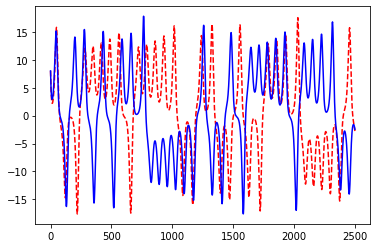

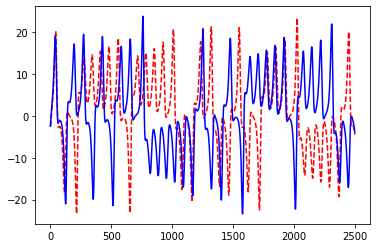

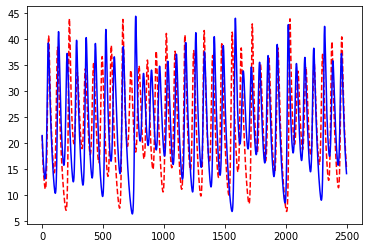

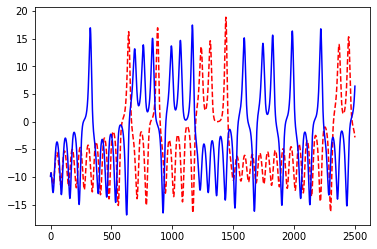

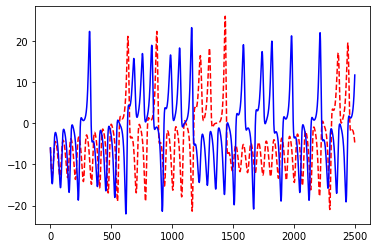

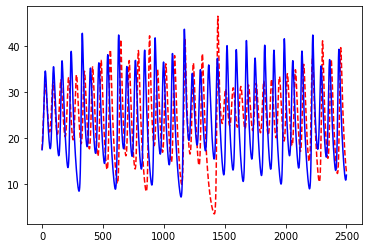

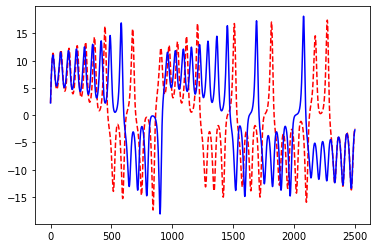

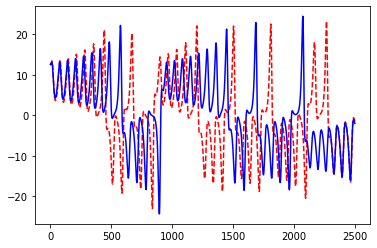

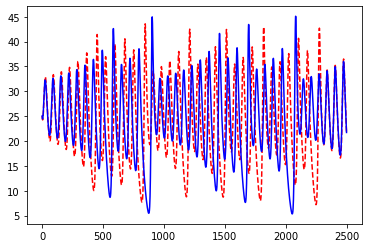

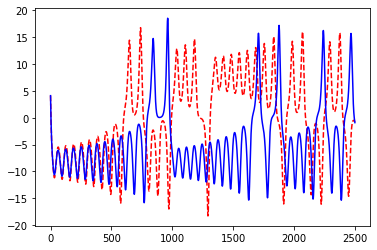

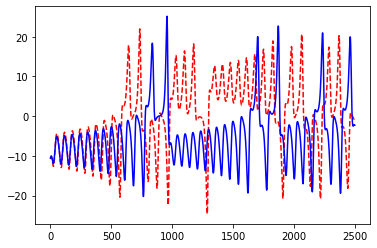

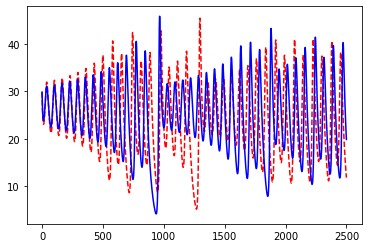

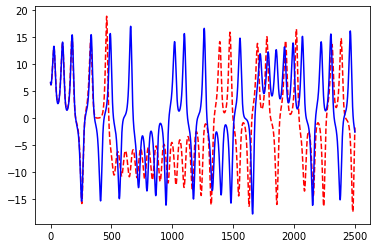

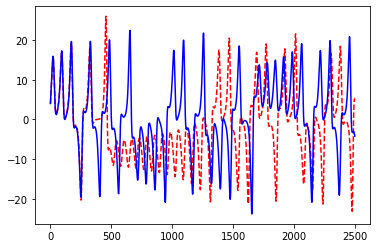

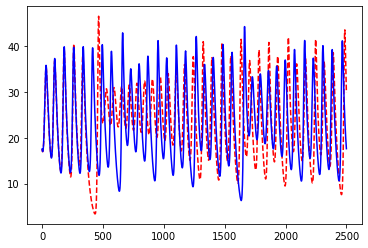

In [ ]:
l2_list = []
for i in range(5):
  ini_cond = [lorenz_data[25+i, 0, 0],lorenz_data[25+i, 1, 0],lorenz_data[25+i, 2, 0]]

  sol = solve_ivp(gradient_function, [0,25], ini_cond, t_eval = np.linspace(0,25,2501))
  #sol_true = solve_ivp(Lorenz, [0,25], ini_cond, t_eval = np.linspace(0,25,2501))
  plt.figure()
  plt.plot(sol['y'][0,:],'--r')
  plt.plot(lorenz_data[25+i,0,:],'b')

  plt.figure()
  plt.plot(sol['y'][1,:],'--r')
  plt.plot(lorenz_data[25+i,1,:],'b')

  plt.figure()
  plt.plot(sol['y'][2,:],'--r')
  plt.plot(lorenz_data[25+i,2,:],'b')
  l2 = np.sqrt(np.sum((lorenz_data[25+i:25+i+1,:,:] - sol['y'])**2))
  l2_or = np.sqrt(np.sum((lorenz_data[25+i:25+i+1,:,:])**2))
  l2_list.append(l2/l2_or)

In [ ]:
np.mean(l2_list)

0.715153440590546